# Accessing Global Forecast System (GFS) data and simple visualization

### References:
- https://www.nco.ncep.noaa.gov/pmb/products/gfs/#GFS

#### Define a function `file_path()` to fetch the urls in public Azure container

In [1]:
import os

def file_path(cycle_runtime:str, forecast_hour:str, year:int, month:str, day:str, resolution_degree:float) -> str:
    
    prefix_path = "https://noaagfs.blob.core.windows.net/"
    product_name = "gfs"
    
    if len(cycle_runtime) == 1:
        cycle_runtime = cycle_runtime.rjust(2, '0')

    if len(forecast_hour) != 3:
        forecast_hour = forecast_hour.rjust(3, '0')

    if len(month) == 1:
        month = month.rjust(2, '0')

    if len(day) == 1:
        day = day.rjust(2, '0')

    if len(str(resolution_degree).split('.')[1]) == 1:
        split_resolution_degree = []
        split_resolution_degree.append(str(resolution_degree).split('.')[0])
        split_resolution_degree.append(str(resolution_degree).split('.')[1].ljust(2, '0'))
    else:
        split_resolution_degree = str(resolution_degree).split('.')

    file_path = (
            f"{product_name}/{product_name}.{year}{month}{day}/"
            f"{cycle_runtime}/atmos/{product_name}.t{cycle_runtime}z."
            f"pgrb2.{split_resolution_degree[0]}p{split_resolution_degree[1]}.f{forecast_hour}"
            )
    
    whole_path = os.path.join(prefix_path, file_path)

    return whole_path


#### Define a function `read_into_xarray_dataset()` to read given url into xarray dataset

References for different keywords:

        filter_by_keys={'typeOfLevel': 'meanSea'}
        filter_by_keys={'typeOfLevel': 'hybrid'}
        filter_by_keys={'typeOfLevel': 'atmosphere', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'atmosphere', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'surface', 'stepType': 'accum'}
        filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
        filter_by_keys={'typeOfLevel': 'isobaricInPa'}
        filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
        filter_by_keys={'typeOfLevel': 'heightAboveGround'}
        filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
        filter_by_keys={'typeOfLevel': 'heightAboveSea'}
        filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
        filter_by_keys={'typeOfLevel': 'lowCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'lowCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'middleCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'middleCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'highCloudLayer', 'stepType': 'instant'}
        filter_by_keys={'typeOfLevel': 'highCloudLayer', 'stepType': 'avg'}
        filter_by_keys={'typeOfLevel': 'cloudCeiling'}
        filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
        filter_by_keys={'typeOfLevel': 'tropopause'}
        filter_by_keys={'typeOfLevel': 'maxWind'}
        filter_by_keys={'typeOfLevel': 'isothermZero'}
        filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'}
        filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
        filter_by_keys={'typeOfLevel': 'sigmaLayer'}
        filter_by_keys={'typeOfLevel': 'sigma'}
        filter_by_keys={'typeOfLevel': 'potentialVorticity'}
 

In [2]:
import xarray as xr
import urllib.request
from urllib.error import HTTPError
from typing import Optional

def read_into_xarray_dataset(URL:str, level:str, step:Optional[str] = None):
    
    try:
        filename, _ = urllib.request.urlretrieve(URL)

        step_key = ['atmosphere', 'surface', 'lowCloudLayer', 'middleCloudLayer', 'highCloudLayer']
        
        if level in step_key:
            ds = xr.open_dataset(filename, engine="cfgrib", filter_by_keys={'typeOfLevel': level, 'stepType': step}, backend_kwargs = {'errors' : 'ignore'})
        else:
            ds = xr.open_dataset(filename, engine="cfgrib", filter_by_keys={'typeOfLevel': level}, backend_kwargs = {'errors' : 'ignore'})
        
        return ds

    except HTTPError as err:

        if err.code == 404:
            
            print(f"{URL} does not exist. Please check the parameters again.")

In [3]:
URL = file_path('12', '102', 2024, '6', '10', 0.5)
ds = read_into_xarray_dataset(URL, 'surface', 'accum')
ds

<xarray.Dataset>
Dimensions:     (latitude: 361, longitude: 720)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude   (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
    valid_time  datetime64[ns] ...
Data variables:
    tp          (latitude, longitude) float32 ...
    acpcp       (latitude, longitude) float32 ...
    watr        (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-06-11T15:30 GRIB to CDM+CF via cfgrib-0.9.1...

#### Simple visualization of gfs data

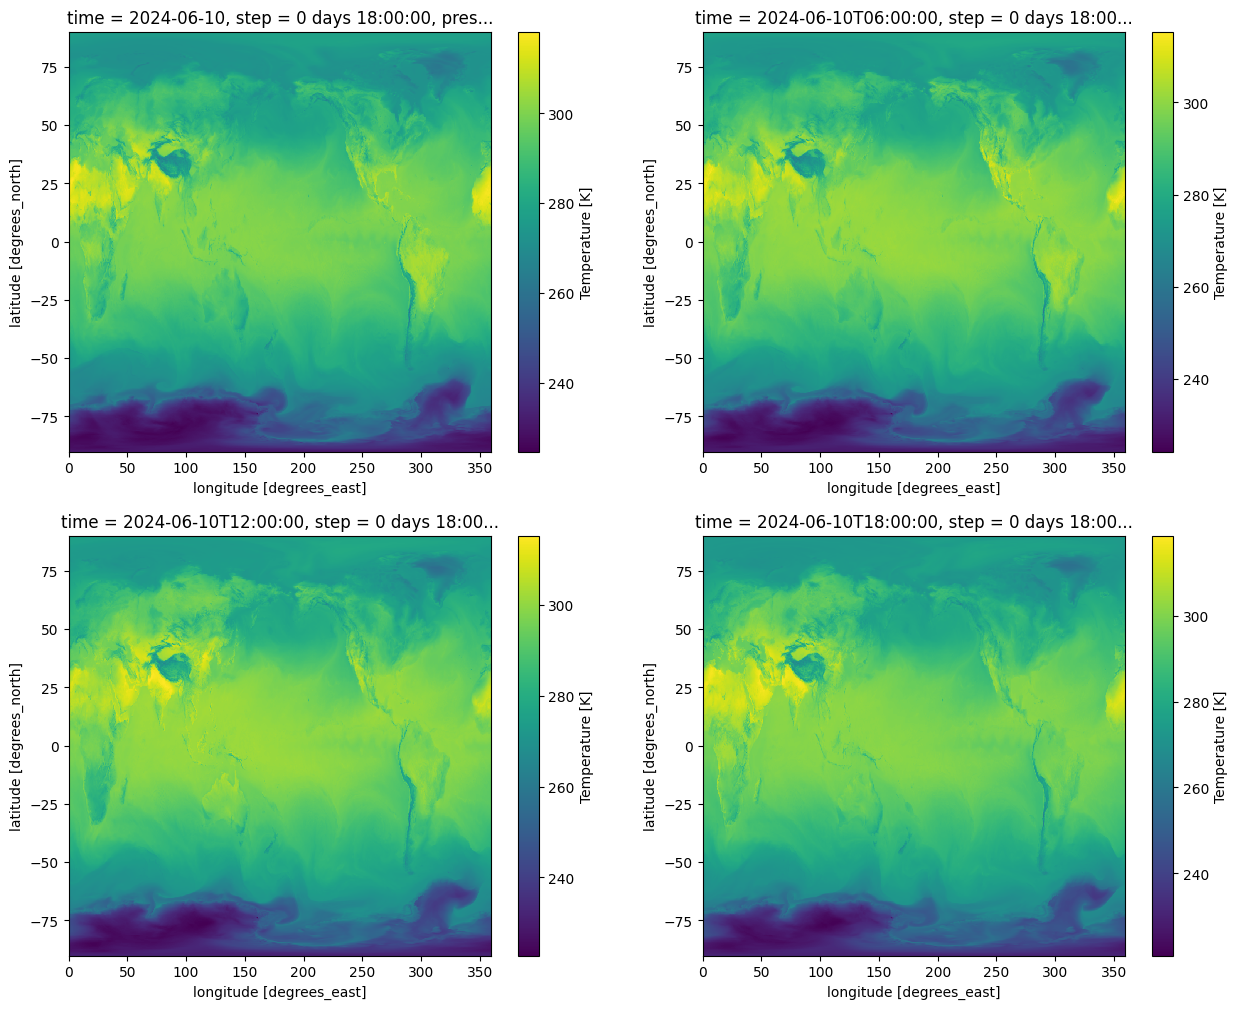

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

for n, cycle in enumerate(['00', '06', '12', '18']):
       
    URL = file_path(cycle, '018', 2024, '06', '10', 0.25)

    ds = read_into_xarray_dataset(URL, 'pressureFromGroundLayer')

    ax = plt.subplot(2, 2, n + 1)
    
    ds['t'].plot(ax = ax)  
